# Dog Breed Image Classification

## Tommy Sullivan, UChicago Masters in Applied Data Science

In [68]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

%matplotlib inline

import tensorflow as tf
import keras
from keras.models import Sequential
import keras_tuner
from keras_tuner.tuners import RandomSearch
from tensorflow.keras import layers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import ResNet50

#### Load and process data

In [2]:
dataset_path = '/Users/thomassullivan/Downloads/Machine Learning/DL Project/dog-breeds'
images = []
labels = []
for folder_name in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder_name)
    if os.path.isdir(folder_path):
        for image_name in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_name)
            image = cv2.imread(image_path)
            # Resize the image 
            image = cv2.resize(image, (224, 224))
            
            # Normalize the image pixel values to a range of 0 to 1
            image = image.astype(np.float32) / 255.0
            images.append(image)
            labels.append(folder_name)

images = np.array(images)
labels = np.array(labels)

#### Print few images for each breed

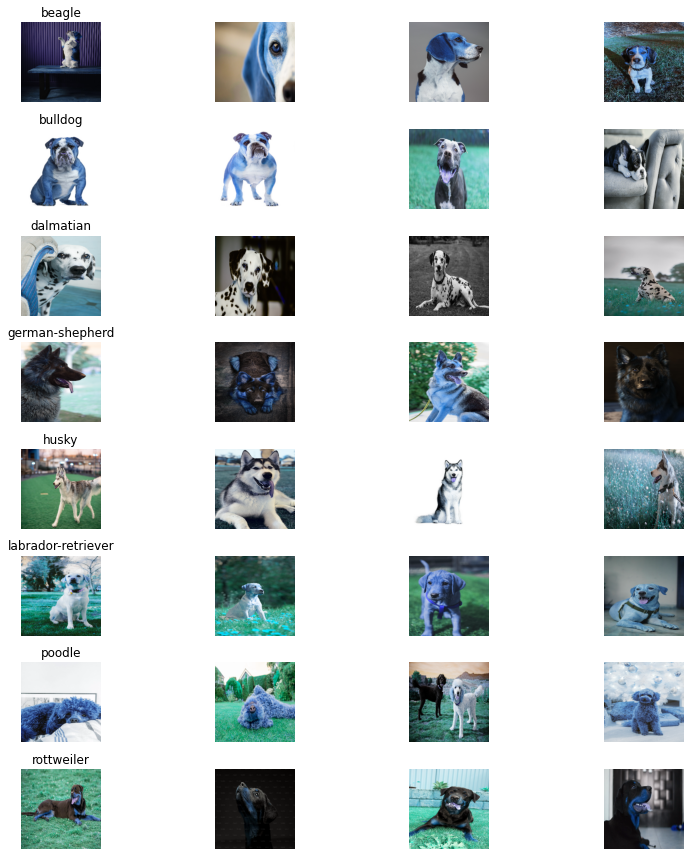

In [5]:
num_images_per_breed = 4
num_classes=8
breeds = np.unique(labels)

fig, axes = plt.subplots(nrows=num_classes, ncols=num_images_per_breed, figsize=(12, 12))
for i in range(num_classes):
    breed_images = np.array(images)[np.array(labels) == breeds[i]]  
    breed_images = breed_images[:num_images_per_breed]  
    for j in range(num_images_per_breed):
        axes[i, j].imshow(breed_images[j])
        axes[i, j].axis('off')
    
    #set title of subplot as breed name
    axes[i, 0].set_title(breeds[i])

plt.tight_layout()

plt.show()

#### Get count of each breed, plot distribution

In [6]:
breeds = np.unique(labels)
breed_sums = {}
for breed in breeds:
    breed_sum = np.sum(labels == breed)
    breed_sums[breed] = breed_sum

print(breed_sums)

{'beagle': 83, 'bulldog': 76, 'dalmatian': 51, 'german-shepherd': 76, 'husky': 71, 'labrador-retriever': 50, 'poodle': 56, 'rottweiler': 78}


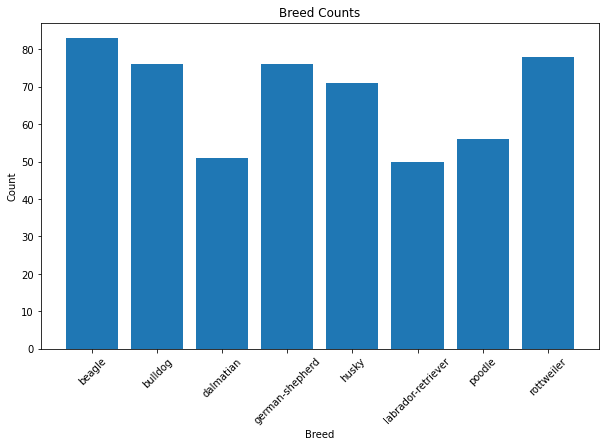

In [7]:
# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(breed_sums.keys(), breed_sums.values())
plt.xlabel('Breed')
plt.ylabel('Count')
plt.title('Breed Counts')
plt.xticks(rotation=45)

plt.show()

A few classes have slightly fewer pictures than others but the imbalance is not too significant. Accuracy should still be appropriate metric

#### Split train and test data, stratify on breed

In [9]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, stratify = labels, random_state=42)

num_classes=8
#create instance of LabelEncoder
label_encoder = LabelEncoder()

#encode string labels into integers
y_train_int = label_encoder.fit_transform(y_train)
y_test_int = label_encoder.fit_transform(y_test)

#convert encoded labels to one-hot encoded vectors
y_train_encoded = to_categorical(y_train_int, num_classes)
y_test_encoded = to_categorical(y_test_int, num_classes)

## Model 1 - Basic CNN

#### Build initial classifier

In [10]:
num_classes=8

#create instance of Sequential model
model = Sequential()
#add Conv2D layer
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=X_train[1].shape, activation='relu'))

#add MaxPooling2D layer
model.add(MaxPooling2D(pool_size=(2, 2)))

#add another Conv2D layer
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))

#add another MaxPooling2D layer
model.add(MaxPooling2D(pool_size=(2, 2)))

#add flatten layer
model.add(Flatten())

#add dense layer
model.add(Dense(units=128, activation='relu'))

#add final dense layer
model.add(Dense(units=num_classes, activation='softmax'))

#compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 128)               2

#### Fit classifier to training data

In [15]:
cnn_fitting = model.fit(
    X_train,
    y_train_encoded,
    steps_per_epoch=11,
    epochs=5,
    validation_split=0.2)

Epoch 1/5
11/11 [==============================] - 14s 1s/step - loss: 6.1227 - accuracy: 0.1623 - val_loss: 1.9684 - val_accuracy: 0.2069
Epoch 2/5
11/11 [==============================] - 13s 1s/step - loss: 1.7618 - accuracy: 0.3768 - val_loss: 1.6637 - val_accuracy: 0.4943
Epoch 3/5
11/11 [==============================] - 16s 2s/step - loss: 0.9699 - accuracy: 0.7623 - val_loss: 1.2575 - val_accuracy: 0.5517
Epoch 4/5
11/11 [==============================] - 17s 2s/step - loss: 0.3751 - accuracy: 0.8812 - val_loss: 1.1507 - val_accuracy: 0.6322
Epoch 5/5
11/11 [==============================] - 19s 2s/step - loss: 0.1139 - accuracy: 0.9826 - val_loss: 1.1310 - val_accuracy: 0.7701


#### Make predictions and print accuracy

In [16]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
accuracy = np.mean(y_pred_classes == y_test_int)

train_pred = model.predict(X_train)
train_pred_classes = np.argmax(train_pred, axis=1)
accuracy_train = np.mean(train_pred_classes == y_train_int)

print("Train Accuracy:", accuracy_train)
print("Test Accuracy:", accuracy)

14/14 [==============================] - 5s 379ms/step
Train Accuracy: 0.9490740740740741
Test Accuracy: 0.7431192660550459


#### Plot Train and Validation Error

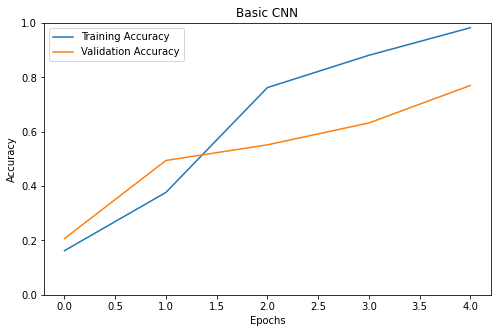

In [18]:
train_accuracy = cnn_fitting.history['accuracy']
val_accuracy = cnn_fitting.history['val_accuracy']

plt.figure(figsize=(8, 5))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Basic CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

Simple CNN has a 74% Test Accuracy. This will be used as the first benchmark to compare with other transfer learning models

## Model 2 - Transfer Learning with InceptionV3

#### Load the pre-trained InceptionV3 model without the top layers, freeze pre-trained layers


In [27]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

In [28]:
#add new layers on top
model_v3 = Sequential()
model_v3.add(base_model)
model_v3.add(Flatten())
model_v3.add(Dense(128, activation='relu'))
model_v3.add(Dense(num_classes, activation='softmax'))

model_v3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
model_v3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_2 (Flatten)         (None, 51200)             0         
                                                                 
 dense_4 (Dense)             (None, 128)               6553728   
                                                                 
 dense_5 (Dense)             (None, 8)                 1032      
                                                                 
Total params: 28,357,544
Trainable params: 6,554,760
Non-trainable params: 21,802,784
_________________________________________________________________


In [30]:
v3_fitting = model_v3.fit(X_train, y_train_encoded, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
11/11 [==============================] - 26s 2s/step - loss: 9.1673 - accuracy: 0.5681 - val_loss: 0.4116 - val_accuracy: 0.9425
Epoch 2/5
11/11 [==============================] - 26s 2s/step - loss: 0.3765 - accuracy: 0.9623 - val_loss: 0.8273 - val_accuracy: 0.9080
Epoch 3/5
11/11 [==============================] - 33s 3s/step - loss: 0.0790 - accuracy: 0.9913 - val_loss: 0.2371 - val_accuracy: 0.9655
Epoch 4/5
11/11 [==============================] - 35s 3s/step - loss: 2.1215e-04 - accuracy: 1.0000 - val_loss: 0.3226 - val_accuracy: 0.9655
Epoch 5/5
11/11 [==============================] - 36s 3s/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.3168 - val_accuracy: 0.9655


In [31]:
v3_fitting

In [32]:
#make predictions
y_pred_v3 = model_v3.predict(X_test)
y_pred_classes_v3 = np.argmax(y_pred_v3, axis=1)
accuracy_v3 = np.mean(y_pred_classes_v3 == y_test_int)

train_pred_v3 = model_v3.predict(X_train)
train_pred_classes_v3 = np.argmax(train_pred_v3, axis=1)
accuracy_train_v3 = np.mean(train_pred_classes_v3 == y_train_int)

print("Train Accuracy:", accuracy_train_v3)
print("Test Accuracy:", accuracy_v3)

14/14 [==============================] - 28s 2s/step
Train Accuracy: 0.9930555555555556
Test Accuracy: 0.944954128440367


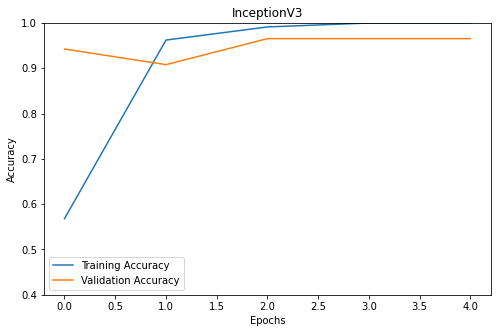

In [53]:
#plot train and validation error
train_accuracy_v3 = v3_fitting.history['accuracy']
val_accuracy_v3 = v3_fitting.history['val_accuracy']

plt.figure(figsize=(8, 5))
plt.plot(train_accuracy_v3, label='Training Accuracy')
plt.plot(val_accuracy_v3, label='Validation Accuracy')
plt.title('InceptionV3')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.4, 1)
plt.legend()
plt.show()

## Model 3 - Transfer Learning with Xception

In [34]:
#load pre-trained Xception model without top classification layer
base_model_x = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#freeze the pre-trained layers
for layer in base_model_x.layers:
    layer.trainable = False

In [35]:
#add new layers on top
model_x = Sequential()
model_x.add(base_model)
model_x.add(Flatten())
model_x.add(Dense(128, activation='relu'))
model_x.add(Dense(num_classes, activation='softmax'))

model_x.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [52]:
model_x.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_3 (Flatten)         (None, 51200)             0         
                                                                 
 dense_6 (Dense)             (None, 128)               6553728   
                                                                 
 dense_7 (Dense)             (None, 8)                 1032      
                                                                 
Total params: 28,357,544
Trainable params: 6,554,760
Non-trainable params: 21,802,784
_________________________________________________________________


In [36]:
xc_fitting = model_x.fit(X_train, y_train_encoded, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
11/11 [==============================] - 36s 3s/step - loss: 5.9674 - accuracy: 0.6522 - val_loss: 1.5295 - val_accuracy: 0.8736
Epoch 2/5
11/11 [==============================] - 32s 3s/step - loss: 0.7824 - accuracy: 0.9478 - val_loss: 1.5212 - val_accuracy: 0.9310
Epoch 3/5
11/11 [==============================] - 35s 3s/step - loss: 0.1061 - accuracy: 0.9797 - val_loss: 2.2164 - val_accuracy: 0.9195
Epoch 4/5
11/11 [==============================] - 34s 3s/step - loss: 4.2365e-04 - accuracy: 1.0000 - val_loss: 2.2620 - val_accuracy: 0.9310
Epoch 5/5
11/11 [==============================] - 33s 3s/step - loss: 9.4962e-05 - accuracy: 1.0000 - val_loss: 2.3043 - val_accuracy: 0.9310


In [37]:
y_pred_x = model_x.predict(X_test)
y_pred_classes_x = np.argmax(y_pred_x, axis=1)
accuracy_x = np.mean(y_pred_classes_x == y_test_int)

train_pred_x = model_x.predict(X_train)
train_pred_classes_x = np.argmax(train_pred_x, axis=1)
accuracy_train_x = np.mean(train_pred_classes_x == y_train_int)

print("Train Accuracy:", accuracy_train_x)
print("Test Accuracy:", accuracy_x)

14/14 [==============================] - 27s 2s/step
Test Accuracy: 0.9357798165137615
Train Accuracy: 0.9861111111111112


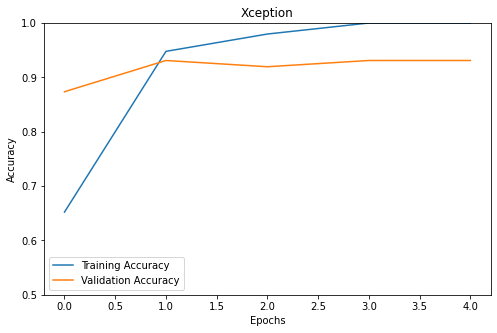

In [54]:
#plot train and validation error
train_accuracy_xc = xc_fitting.history['accuracy']
val_accuracy_xc = xc_fitting.history['val_accuracy']

plt.figure(figsize=(8, 5))
plt.plot(train_accuracy_xc, label='Training Accuracy')
plt.plot(val_accuracy_xc, label='Validation Accuracy')
plt.title('Xception')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.5, 1)
plt.legend()
plt.show()

## Model 4: Transfer Learning with VGG16

In [45]:
base_model_vg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

In [46]:
#add new layers on top
model_vg = Sequential()
model_vg.add(base_model_vg)
model_vg.add(Flatten())
model_vg.add(Dense(128, activation='relu'))
model_vg.add(Dense(num_classes, activation='softmax'))

model_vg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [51]:
model_vg.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 25088)             0         
                                                                 
 dense_10 (Dense)            (None, 128)               3211392   
                                                                 
 dense_11 (Dense)            (None, 8)                 1032      
                                                                 
Total params: 17,927,112
Trainable params: 17,927,112
Non-trainable params: 0
_________________________________________________________________


In [47]:
vg_fitting = model_vg.fit(X_train, y_train_encoded, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
11/11 [==============================] - 334s 30s/step - loss: 3.8274 - accuracy: 0.0870 - val_loss: 2.0573 - val_accuracy: 0.1264
Epoch 2/5
11/11 [==============================] - 329s 30s/step - loss: 2.1342 - accuracy: 0.1362 - val_loss: 2.0583 - val_accuracy: 0.1034
Epoch 3/5
11/11 [==============================] - 324s 30s/step - loss: 2.1441 - accuracy: 0.1594 - val_loss: 2.1269 - val_accuracy: 0.1034
Epoch 4/5
11/11 [==============================] - 335s 30s/step - loss: 2.1102 - accuracy: 0.1072 - val_loss: 2.0789 - val_accuracy: 0.2069
Epoch 5/5
11/11 [==============================] - 313s 29s/step - loss: 2.0795 - accuracy: 0.1072 - val_loss: 2.0795 - val_accuracy: 0.1264


In [48]:
y_pred_vg = model_vg.predict(X_test)
y_pred_classes_vg = np.argmax(y_pred_vg, axis=1)
accuracy_vg = np.mean(y_pred_classes_vg == y_test_int)

train_pred_vg = model_vg.predict(X_train)
train_pred_classes_vg = np.argmax(train_pred_vg, axis=1)
accuracy_train_vg = np.mean(train_pred_classes_vg == y_train_int)

print("Train Accuracy:", accuracy_train_vg)
print("Test Accuracy:", accuracy_vg)

14/14 [==============================] - 114s 8s/step
Train Accuracy: 0.13194444444444445
Test Accuracy: 0.12844036697247707


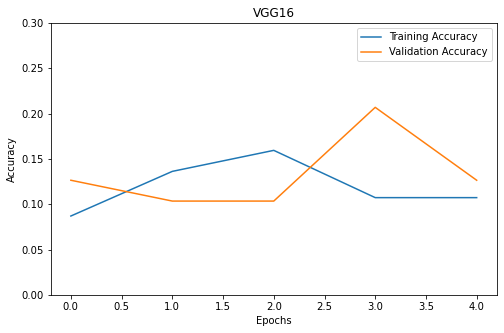

In [55]:
#plot train and validation error
train_accuracy_vg = vg_fitting.history['accuracy']
val_accuracy_vg = vg_fitting.history['val_accuracy']

plt.figure(figsize=(8, 5))
plt.plot(train_accuracy_vg, label='Training Accuracy')
plt.plot(val_accuracy_vg, label='Validation Accuracy')
plt.title('VGG16')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 0.3)
plt.legend()
plt.show()

## Hyperparameter Tuning with Inception V3
Since InceptionV3 had the highest score on the test set, we will fine-tune hyperparameters with that model

In [62]:
!pip install keras_tuner

In [63]:
#define the function to build model
def build_model(hp):
    # Define the InceptionV3 base model
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False
        
    model = tf.keras.Sequential([
        base_model,  
        tf.keras.layers.BatchNormalization(renorm=True),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(hp.Int('dense_units', min_value=64, max_value=256, step=64), activation='relu'),
        tf.keras.layers.Dropout(hp.Float('dropout_rate', min_value=0.05, max_value=0.6, step=0.05)),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[0.001, 0.01, 0.1]))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [64]:
#define tuner object
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='random_search',
    project_name='inceptionv3_random_search'
)

In [65]:
tuner.search(X_train, y_train_encoded, epochs=5, validation_split=0.2)

Trial 5 Complete [00h 01m 54s]
val_accuracy: 0.977011501789093

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 09m 24s
INFO:tensorflow:Oracle triggered exit


In [66]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Print the best hyperparameters
print("Best Hyperparameters:")
print(tuner.get_best_hyperparameters()[0].values)

# Evaluate the best model on the test set
test_loss, test_accuracy = best_model.evaluate(X_test, y_test_encoded)
print("Test Accuracy:", test_accuracy)

Best Hyperparameters:
{'dense_units': 256, 'dropout_rate': 0.1, 'learning_rate': 0.01}
4/4 [==============================] - 5s 742ms/step - loss: 0.7899 - accuracy: 0.9541
Test Accuracy: 0.9541284441947937


In [67]:
#print confusion matrix
y_pred_best = best_model.predict(X_test)
y_pred_classes_best = np.argmax(y_pred_best, axis=1)

cm_best = confusion_matrix(y_test_int, y_pred_classes_best)
print(cm_best)

4/4 [==============================] - 4s 761ms/step
[[17  0  0  0  0  0  0  0]
 [ 0 14  0  1  0  0  0  1]
 [ 0  0 10  0  0  0  0  0]
 [ 0  0  0 15  0  0  0  0]
 [ 0  0  0  0 14  0  0  0]
 [ 0  0  0  0  0  8  1  1]
 [ 0  0  0  0  0  0 11  0]
 [ 0  0  0  0  0  0  1 15]]


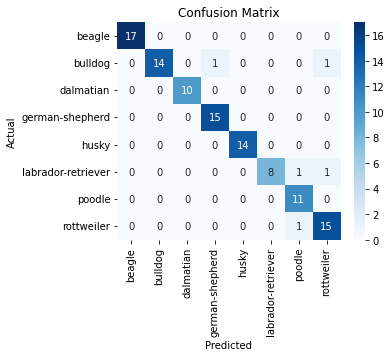

In [71]:
y_pred_labels = label_encoder.inverse_transform(y_pred_classes_best)
cm_labels = confusion_matrix(y_test, y_pred_labels)
#plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm_labels, annot=True, fmt='d', cmap='Blues', xticklabels=breeds, yticklabels=breeds)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()